# Histogram of GOES-16, GOES-17, Empirical CDF, and AUC for Full disk samples in region of interest.

## Import libraries

In [42]:
#import urllib.request
import numpy as np
import scipy.stats as st
import itertools
import pandas as pd
# npPath = '/sharedData/scratch/all_npy3/'
# ncPath = '/sharedData/scratch/april_data/'
# acmPath = '/sharedData/scratch/all_npy3/'
# DATAPATH = '/sharedData/scratch/'
import requests
import re
import os
#import os.path as op
from os import path as op
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import metpy
import cartopy.crs as ccrs
from pyresample import image, geometry
import seaborn as sns #ref
import netCDF4
sns.set(style="darkgrid")
from pathlib import Path
from subprocess import Popen

import matplotlib.dates as mdates
from datetime import datetime

In [43]:
import logging
logger = logging.getLogger()

## Define paths

In [44]:
storage = Path('../storage/')

## Functions for unfiltered cloud mask

In [45]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [46]:
def createUnfilteredPlotArray(ncFile,npFile,npPath):#Filtered Histrogram for cloud clear sky mask
    Tmean= []
    times = []
    for ncf, npf in zip(ncFile, npFile):
        imageBox = np.load(op.join(npPath,npf))
        myFile = xr.open_dataset(op.join(ncPath,ncf))
        planck_fk1 = float(myFile['planck_fk1'].data)
        planck_fk2 = float(myFile['planck_fk2'].data) 
        planck_bc1 = float(myFile['planck_bc1'].data)                       
        planck_bc2 = float(myFile['planck_bc2'].data)     
        T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        tString = ncf[31:38]
        times.append(tString)
        Tmean.append(T)
    return times, Tmean

In [47]:
def listurls(prefix,html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html.text)
    urllist = [elt['href'] for elt in soup.find_all(href=re.compile(prefix))]
    return urllist

In [48]:
def create_nc_Numpy(ncFile, pathOut):
    myFile = xr.open_dataset(ncFile,engine="netcdf4")
    dat = myFile.metpy.parse_cf('Rad')#myFile['Rad']
    geos = dat.metpy.cartopy_crs

    cartopy_extent_goes = geos.x_limits + geos.y_limits
    pyresample_extent_goes = (cartopy_extent_goes[0],
                                cartopy_extent_goes[2],
                                cartopy_extent_goes[1],
                                cartopy_extent_goes[3])
    goes_params = geos.proj4_params
    rad = dat.data
    
    def normIm(im,gamma=1.0,reverse=False):
        nim = ((im-np.nanmin(im))*(np.nanmax(im)-np.nanmin(im))**(-1))
        if reverse:#want clouds to be white
            nim = (1.0-nim**(gamma))
        return nim
    
    def goes_2_roi(geos_crs, 
               target_extent,
               target_rows,#actual length or base
               target_cols,#actual width or height
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):
        """Function that goes from loaded GOES data to data resampled in a projection for an extent"""
        cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
        pyresample_source_extent = (cartopy_source_extent[0],
                                    cartopy_source_extent[2],
                                    cartopy_source_extent[1],
                                    cartopy_source_extent[3])
        rad = dat.data
        source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk','GOES-1X', 
                                              geos_crs.proj4_params,
                                              rad.shape[1], rad.shape[0],
                                              pyresample_source_extent)
        area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                            cartopy_target_proj.proj4_params,
                                            target_rows, target_cols,
                                            target_extent)
        geos_con_nn = image.ImageContainerNearest(rad, 
                                                source_area, 
                                                radius_of_influence=radius_of_influence)

        # Here we are using pyresample for the remapping
        area_proj_con_nn = geos_con_nn.resample(area_target_def)
        return area_proj_con_nn.image_data
        
    def cartopy_pyresample_toggle_extent(input_extent):
        return np.array(input_extent)[np.array([0,2,1,3])]

    def transform_cartopy_extent(source_extent,source_proj, target_proj):
        target_extent = target_proj.transform_points(source_proj, 
                                                     np.array(source_extent[:2]),
                                                     np.array(source_extent[2:])).ravel()
        # target_extent in 3D, must be in 2D
        return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])
    pc = ccrs.PlateCarree()
    mc = ccrs.Mercator()

    # Convert extent from pc to mc (both cylindrical projections)
    extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]
    
    target_extent_mc_cartopy = transform_cartopy_extent(extent_pc, pc, mc)
    target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
    
    roi_rads = goes_2_roi(geos,
               target_extent_mc_pyresample,
               401,1001,
               mc)
    ####
    full_filename = op.join(pathOut,ncFile[:-3])
    np.save(full_filename,roi_rads)
    myFile.close()
    return

In [49]:
def download(url,toPath, saveName):
    cmd = [ 'wget ' + url +' -P ' + toPath +' -O '+ saveName]#if re.search('C07',url)
    print(cmd)
    pid = Popen(cmd, shell=True)
    pid.communicate()
    return

# Execution

In [50]:
Sat = 16
band = 8
year = 2020
month = 1
day = 1
hour = 0

[(0, 'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2020/001/00/OR_ABI-L1b-RadF-M6C08_G16_s20200010000216_e20200010009524_c20200010010002.nc'), (1, 'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2020/001/00/OR_ABI-L1b-RadF-M6C08_G16_s20200010010216_e20200010019524_c20200010019593.nc'), (2, 'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2020/001/00/OR_ABI-L1b-RadF-M6C08_G16_s20200010020216_e20200010029524_c20200010029599.nc'), (3, 'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2020/001/00/OR_ABI-L1b-RadF-M6C08_G16_s20200010030216_e20200010039524_c20200010040002.nc'), (4, 'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2020/001/00/OR_ABI-L1b-RadF-M6C08_G16_s20200010040216_e20200010049524_c20200010049598.nc'), (5, 'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2020/001/00/OR_ABI-L1b-RadF-M6C08_G16_s20200010050216_e20200010059524_c20200010059599.nc')]


ValueError: not enough values to unpack (expected 4, got 2)

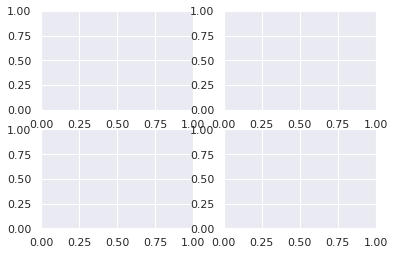

In [53]:
search = itertools.product([Sat], [band], [year], [month], [day], [hour])
bins = np.linspace(220,250,101)
log = open('log_Histogram.txt','w')

#check for GOES-16 and GOES-17 and plot what is available
for SS, bb, yyyy, mm, dd, hr in search:
    SS, bb, yyyy, mm, dd, hr = \
        str(SS).zfill(2),\
        str(bb).zfill(2),\
        str(yyyy).zfill(4),\
        str(mm).zfill(2),\
        str(dd).zfill(2),\
        str(hr).zfill(2)
    templateURL = f'http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/'\
    + f'goes16_download.cgi?source=aws&satellite='\
    + f'noaa-goes{SS}&domain=F&product=ABI-L1b-Rad&date={yyyy}-{mm}-{dd}&hour={hr}'
    
    '''Get URLS for download'''
    req16 = requests.get(templateURL)
   
    SS = '17'
    req17 = requests.get(templateURL)
    
    if yyyy == '2018':
        product = '3'
    else:
        product = '6'
    prefix = f"OR_ABI-L1b-RadF-M{product}C" + bb
    prefix.format(**{'product':product})
    bandURLList16 = listurls(prefix,req16)#list of strings using beautiful soup
    bandURLList17 = listurls(prefix,req17)
    bandURLList16.sort()
    bandURLList17.sort()
    
    cnt = 0 #keep a counter to avoid crossing FD with similar file names and performance
    '''iterate over pairs of GOES NETCDF, download, and convert to numpy'''
    print(list(enumerate(bandURLList16)))
    for i, FD16 in enumerate(bandURLList16): #Last string chars are of this format: c20192220009464.nc   
        print(str(FD16), file=log)        
        cYYYYDDDHHt = FD16[-18:-7]
        t = FD16[-7]
        for FD17 in bandURLList17[cnt:i]:
            if cYYYYDDDHHt == FD17[-18:-7]:
                cnt +=1
                download17 = requests.get(FD17)
                nc17 = open('nc17.nc','wb')
                nc17.write(download17.content)
                nc17.close()
                npy17 = create_nc_Numpy('nc17.nc', '.')
                
                '''Load numpy files'''
                imageBox_17 = np.load('nc17.npy')
                myFile_17 = xr.open_dataset('nc17.nc')
                planck_fk1 = float(myFile_17['planck_fk1'].data)
                planck_fk2 = float(myFile_17['planck_fk2'].data) 
                planck_bc1 = float(myFile_17['planck_bc1'].data)                       
                planck_bc2 = float(myFile_17['planck_bc2'].data)
                break
        download16 = requests.get(FD16)
        nc16 = open('nc16.nc','wb')
        nc16.write(download16.content)
        nc16.close()
        npy16 = create_nc_Numpy('nc16.nc', '.')

        '''Load numpy files'''
        imageBox_16 = np.load('nc16.npy')
        myFile_16 = xr.open_dataset('nc16.nc')
        planck_fk1_16 = float(myFile_16['planck_fk1'].data)
        planck_fk2_16 = float(myFile_16['planck_fk2'].data) 
        planck_bc1_16 = float(myFile_16['planck_bc1'].data)                       
        planck_bc2_16 = float(myFile_16['planck_bc2'].data)
 
        '''Create subplot figures and save'''
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(2, 2)
        
        '''Histograms'''
        ax1.set_title(f'GOES-16 ABI Band {bb} Day {mm}-{dd} {hh}:{t}0')
        ax1.set_ylabel('density (unitless)',fontsize = 16)
        ax1.set_xlabel('Temperature (K)', fontsize = 16)
        Tbox16 = Rad2BT(imageBox_16, planck_fk1_16, planck_fk2_16, planck_bc1_16, planck_bc2_16)
        ax1.hist(Tbox16.ravel(), bins = bins, density = True, label = 'Temp dist.')
        ax1.axvline(Tbox16.mean(), color='r',label = 'NOAA avg.')
        ax1.legend(loc='upper left')
        
        if cYYYYDDDHHt == FD17[-18:-7]:
            ax2.set_title(f'GOES-17 ABI Band {bb} Day {mm}-{dd} {hh}:{t}0')
            ax2.set_ylabel('density (unitless)',fontsize = 16)
            ax2.set_xlabel('Temperature (K)', fontsize = 16)
            Tbox17 = Rad2BT(imageBox_17, planck_fk1_17, planck_fk2_17, planck_bc1_17, planck_bc2_17)
            ax2.hist(Tbox17.ravel(), bins = bins, density = True, label = 'Temp dist.')
            ax2.axvline(Tbox17.mean(), color='r',label = 'NOAA avg.')
            ax2.legend(loc='upper left')

            '''ECDF'''
            xticks = [st.scoreatpercentile(xticks, p) for p in [0, 25, 50, 75, 100]]
            ax3.plot(sorted(G17), label='G17')
            ax3.plot(sorted(G16), label='G16')
            ax3.legend(loc = 'upper left')
            ax3.set_title(f'Empirical CDF for Apr-{day}-2019')
            ax3.set_xticks(xticks)
            ax3.set_xticklabels(plabels)
            ax3.set_xlabel('quantiles')
            ax3.set_ylabel('Temperature')

            '''AUC'''
            rc= np.vstack([Tbox16.ravel(), Tbox17.ravel()])
            XY = rc[:,np.isfinite(rc).all(axis=0)]
            G16 = XY[0]
            G17 = XY[1]

            _G17 = np.linspace(G17.min(), G17.max(), 1000)
            B = [st.scoreatpercentile(G16, st.percentileofscore(G17,g17s,
                kind='strict')) for g17s in _G17]

            _B = (B - min(B))/(max(B) - min(B))
            _G17n = (_G17 - min(_G17))/(max(_G17) - min(_G17))

            AUC = round(sum(_B)/1000,5)
            chart[ts] = AUC
            
            ax4.plot(_G17n,_B, label=f"AUC: {AUC}")
            ax4.set_ylabel('G16')
            ax4.set_xlabel('G17')
            ax4.set_title('Transform of G17 to G16')
            ax4.set_aspect('equal')
            ax4.legend(loc = 'upper left')
        
        #ax.plot([T,T], [0,0.3],'r', label = 'something')
        YYYY = FD16[-17:-13]
        DDD = FD16[-13:-10]
        HH = FD16[-10:-8]
        MM = FD16[-8:-6]
        fig.savefig(op.join(storage,f"GOES-R_panel_GOES16vsGOES17_FD_{YYYY}{DDD}{HH}{MM}_Band{bb}.png"))
        #GOES17_FPMTemp_GOES16vsGOES17MeanDiff_FD_2020357_000032_Band08.png
#     times17, mean17 = getTmean('17', npPath, band, day)
#     times16, mean16 = getTmean('16', npPath, band, day)

#     ptimes17 = [datetime.strptime(f"2019{t}", "%Y%j%H%M") for t in times17]
#     ptimes16 = [datetime.strptime(f"2019{t}", "%Y%j%H%M") for t in times16]
#     fig, ax1 = plt.subplots(figsize=(15,5))#constrained_layout=False
#     _ = ax1.plot_date(ptimes17, mean17 , label="GOES-17", color='tab:red', marker='+', markersize = 16)
#     _ = ax1.plot_date(ptimes16, mean16 , label='GOES-16', color='tab:blue', marker='+', markersize = 16, zorder=-1)
#     _ = ax1.set_ylim(220,260)
#     _ = ax1.tick_params('both', labelsize=18)
#     _ = ax1.legend()
#     _ = ax1.set_title(f'Mean Temperatures (K) for a 401 x 1001 Portion\n of Band 08 on 04-{str(8+j)}-2019', fontweight ='bold', fontsize = 22)
#     _ = ax1.set_ylabel('Temperature (K)',fontsize = 16)
#     _ = ax1.set_xlabel('time (hours)',fontsize = 16)
#     _ = ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


#     _ = plt.savefig('..'+ op.join(DATAPATH,f"Mean_temp_unfiltered/04-{str(8+j).zfill(2)}-2019"))
